In [4]:
#Installing essential modules for future code use
!pip install basemap
!pip install basemap-data
!pip install prettytable

In [5]:
# Modules required for the funtioning of the code provided 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import math 
import random 
from copy import copy
import json 
from prettytable import PrettyTable

# To ignore any warnings while running code 
import warnings
warnings.filterwarnings('ignore')

Read Input File and Manipulate data for usage

In [6]:
# Read flights information say Flight number, Altitude, Latitude, Longitude from the CSV file
FlightListingData = pd.read_csv('FLIGHT_DATA.csv')

# Set ground station locations with (Latitude, Longitude, Altitude)
HeathrowGS_Coords = [51.47, -0.45, 24.91]    
NewarkGS_Coords = [40.69, -74.17, 2.66]   

# The radius of earth
RadiusOfEarth = 6371000 

# Conversion of given (latitude, longitude, altitude) value 
# to its corresponding cartisian coordinates
def conversionToCartisianCoordinates(node):
    longitude = np.deg2rad(FlightListingData._get_value(node, 'Longitude'))
    latitude = np.deg2rad(FlightListingData._get_value(node, 'Latitude'))
    altitude = FlightListingData._get_value(node, 'Altitude') * 0.304

    X_coord = (RadiusOfEarth + altitude)* math.cos(latitude) * math.cos(longitude) 
    Y_coord = (RadiusOfEarth + altitude)* math.cos(latitude) * math.sin(longitude) 
    Z_coord = (RadiusOfEarth + altitude)* math.sin(latitude) 
    
    return(X_coord,Y_coord,Z_coord)

In [7]:
# Cartisian Coordinates for the ground stations - Heathrow, Newark
latitude = np.deg2rad(HeathrowGS_Coords[0]) 
longitude =  np.deg2rad(HeathrowGS_Coords[1]) 
heathrowGS_coord_x = (RadiusOfEarth + HeathrowGS_Coords[2])* math.cos(latitude) * math.cos(longitude) 
heathrowGS_coord_y = (RadiusOfEarth + HeathrowGS_Coords[2])* math.cos(latitude) * math.sin(longitude) 
heathrowGS_coord_z = (RadiusOfEarth + HeathrowGS_Coords[2])* math.sin(latitude) 
 
latitude = np.deg2rad(NewarkGS_Coords[0]) 
longitude =  np.deg2rad(NewarkGS_Coords[1]) 
newarkGS_coord_x = (RadiusOfEarth + NewarkGS_Coords[2])* math.cos(latitude) * math.cos(longitude) 
newarkGS_coord_y = (RadiusOfEarth + NewarkGS_Coords[2])* math.cos(latitude) * math.sin(longitude) 
newarkGS_coord_z = (RadiusOfEarth + NewarkGS_Coords[2])* math.sin(latitude) 

# Coordinates of Heathrow and Newark ground stations
HeathrowCoordinates = [heathrowGS_coord_x, heathrowGS_coord_y, heathrowGS_coord_z]
NewarkCoordinates = [newarkGS_coord_x, newarkGS_coord_y, newarkGS_coord_z]

# Initializing value for x,y,z coordinates for dataframe
FlightListingData['x_coord'] = 0
FlightListingData['y_coord'] = 0
FlightListingData['z_coord'] = 0

# Converting coordinates of flights in file to cartesian coordinates
for flight, row in FlightListingData.iterrows():
    xcoord,ycoord,zcoord = conversionToCartisianCoordinates(flight)
    FlightListingData['x_coord'][flight] = xcoord
    FlightListingData['y_coord'][flight] = ycoord
    FlightListingData['z_coord'][flight] = zcoord

# Appending cartisian coordinates of Heathrow and Newark to Flight Details
FlightListingData = FlightListingData.append({ 'Flight': 'LHR', 
                    'x_coord': heathrowGS_coord_x, 'y_coord': heathrowGS_coord_y, 
                    'z_coord': heathrowGS_coord_z}, ignore_index = True)
FlightListingData = FlightListingData.append({ 'Flight': 'EWR', 
                    'x_coord': newarkGS_coord_x, 'y_coord': newarkGS_coord_y, 
                    'z_coord': newarkGS_coord_z}, ignore_index = True)

HeathrowGS_id = len(FlightListingData)-2
NewarkGS_id = len(FlightListingData)-1

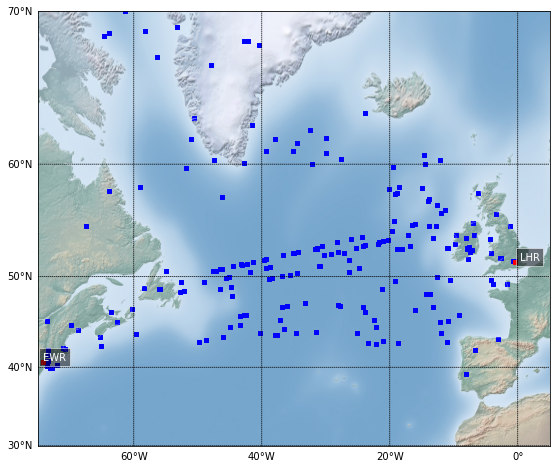

In [8]:
# Representing the Flights and Ground Station on a map
plot = plt.figure(figsize=(12,8))
plot_axes = plt.axes()
map = Basemap(projection= 'merc', llcrnrlat= 30, urcrnrlat= 70,
              llcrnrlon= -75, urcrnrlon= 5)

map.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
map.shadedrelief(scale=0.5)
map.drawparallels(np.arange(-90, 90, 10), labels=[1, 0, 0, 0], zorder=1)
map.drawmeridians(np.arange(-180, 180, 20), labels=[0, 0, 0, 1], zorder=2)

# Plotting Flights
x,y = map(FlightListingData.Longitude.copy(), FlightListingData.Latitude.copy())  
plt.scatter(x, y, 10, marker='s', color='blue') 

# Plotting Ground Stations
x,y = map([HeathrowGS_Coords[1], NewarkGS_Coords[1]], [HeathrowGS_Coords[0], NewarkGS_Coords[0]])
plt.scatter(x,y, 10, marker='s', color = 'red')

atxt = plot_axes.text(0, 0, '', c='w', zorder=5, 
                bbox=dict(facecolor='k', alpha=0.5, edgecolor='w'))
atxt_ = plot_axes.text(0, 0, '', c='w', zorder=5, 
                bbox=dict(facecolor='k', alpha=0.5, edgecolor='w'))
atxt.set_position([x[0]*1.01, y[0]*1.01])
atxt_.set_position([x[1]*1.02, y[1]*1.02])
atxt.set_text('LHR')
atxt_.set_text('EWR')

In [9]:
# Calculate the distance between two nodes, 
# either flight or ground station
def calculateDistanceBetweenTwoNodes(node1, node2):   
    return math.sqrt((node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + 
                     (node1[2]-node2[2])**2)/1000

# Fetch cartisian coordinate of flight or ground station 
# at a particular index
def getCartisianCoordinatesForIndex(index):
    return [FlightListingData.loc[index, 'x_coord'], 
            FlightListingData.loc[index, 'y_coord'], 
            FlightListingData.loc[index, 'z_coord']]

# Given switching thresholds distance and corresponding 
# transmission rates from the problem
def fetchDataRateTransmissionForThreshold(nodeGap):
    dataRate = 0
    if nodeGap > 500: 
        dataRate = 31.895
    elif nodeGap > 400:  
        dataRate = 43.505
    elif nodeGap > 300:  
        dataRate = 52.857
    elif nodeGap > 190:  
        dataRate = 63.970
    elif nodeGap > 90:  
        dataRate = 77.071
    elif nodeGap > 35:  
        dataRate = 93.854
    else: 
        dataRate = 119.130
    return dataRate

# Calculate the distance between two flights or/and ground station
# given the indices of the flights
def fetchDistanceBetweenGivenTwoNodes(flight1, flight2):
    return calculateDistanceBetweenTwoNodes(
                getCartisianCoordinatesForIndex(flight1), 
                getCartisianCoordinatesForIndex(flight2))

In [10]:
# Data formatting for the functioning of the algorithms
HeathrowGS_NearestFlights = []
NewarkGS_NearestFlights = []
DataTransmissionMatrix = []
for flight_no, row in FlightListingData.iterrows():
    matrix = []
    for flight2, row2 in FlightListingData.iterrows():
        if flight2!=flight_no:
            transmissionRate = fetchDataRateTransmissionForThreshold(
                fetchDistanceBetweenGivenTwoNodes(flight_no,flight2))
            matrix.append(transmissionRate)
        else:
            matrix.append(0)
    DataTransmissionMatrix.append(matrix)
    if flight_no not in [HeathrowGS_id, NewarkGS_id]: 
        flightCoords = getCartisianCoordinatesForIndex(flight_no)
        if(calculateDistanceBetweenTwoNodes(HeathrowCoordinates, flightCoords) 
            < calculateDistanceBetweenTwoNodes(NewarkCoordinates, flightCoords)):
            HeathrowGS_NearestFlights.append(flight_no)
        else:
            NewarkGS_NearestFlights.append(flight_no)
            
print(len(HeathrowGS_NearestFlights), len(NewarkGS_NearestFlights))

146 70


In [11]:
# Output formatting for preffered Solution Format
def SolutionFormatForOutputFile(traversedPaths): 
    arrayOfPathFormatted = [] 
    for traversedPath in traversedPaths: 
        GS_index = traversedPath[-1] 
        formattedRoutes = {'Source' : FlightListingData.loc[traversedPath[0],'Flight']} 
        formattedRoutingPaths= [] 
        possible_rate =  fetchDataRateTransmissionForThreshold(
                            fetchDistanceBetweenGivenTwoNodes(
                                GS_index,traversedPath[0]))
        for i in range(len(traversedPath)-1): 
            curr_rate =  fetchDataRateTransmissionForThreshold(
                            fetchDistanceBetweenGivenTwoNodes(
                                traversedPath[i],traversedPath[i+1]))
            formattedRoutingPaths.append((
                FlightListingData.loc[traversedPath[i+1],'Flight'],curr_rate)) 
            if curr_rate < possible_rate: 
                possible_rate = curr_rate
        formattedRoutes['routing path'] = tuple(formattedRoutingPaths) 
        formattedRoutes['End-to-end transmission rate'] = possible_rate 
        arrayOfPathFormatted.append(formattedRoutes) 
    return arrayOfPathFormatted 

In [12]:
# Get the possible best neighbor of current node
def fetchBestNeighbor(neighbors, visited):
    best_neighbor_index = np.argmax(neighbors)
    best_neighbor_value = np.amax(neighbors)
    if(best_neighbor_index in visited):
        neighbors[best_neighbor_index] = 0
        best_neighbor_index, best_neighbor_value = fetchBestNeighbor(neighbors, visited)
    return best_neighbor_index, best_neighbor_value

# Fetch optimized rouths between flights and ground station using Dijkstra Algorithm
def dijkstra(graph):
    visited = set()
    unvisited = list(range(len(graph)-2))
    routes = []
    rates = []
    while len(unvisited)>0:
        localRate = 400
        start_index = random.choice(unvisited)
        current = start_index
        traversedNodes = [current]
        visited.add(current)
        unvisited.remove(current)
        while current not in [HeathrowGS_id,NewarkGS_id]:
            current, current_data_rate = fetchBestNeighbor(graph[current], visited)
            localRate = current_data_rate if localRate > current_data_rate else localRate
            traversedNodes.append(current)
            if current not in [HeathrowGS_id,NewarkGS_id]:
                visited.add(current)
                unvisited.remove(current)
            else:
                break
        routes.append(traversedNodes)
        rates.append(localRate)
    return routes, rates

In [13]:
# Get the possible best transmission rate
def bestPossibleTransmissionRateBetweenNodes(nodes, gs_index): 
    if gs_index == 0:
        possibleBestRate =  fetchDataRateTransmissionForThreshold(
                fetchDistanceBetweenGivenTwoNodes(nodes[0],nodes[1]))
    else: 
        possibleBestRate =  fetchDataRateTransmissionForThreshold(
                fetchDistanceBetweenGivenTwoNodes(gs_index,nodes[-1]))
    for i in range(len(nodes)-1): 
        rateOfNodes =  fetchDataRateTransmissionForThreshold(
                fetchDistanceBetweenGivenTwoNodes(nodes[i],nodes[i+1]))
                
        if rateOfNodes < possibleBestRate: 
            possibleBestRate = rateOfNodes 
    return possibleBestRate 

# Get the maximum possible delay caused
def possibleMaximumLatencyBetweenFlights(flights): 
    return (len(flights)-1) * 50 

def fetchFeasiblePaths(flights, groundStation):      
    possiblePaths = [] 
    possiblePath = [flights[0]] 
    for inc in range(len(flights)): 
 
        if inc != len(flights)-1:
            d1 = fetchDistanceBetweenGivenTwoNodes(flights[inc],groundStation)
            d2 = fetchDistanceBetweenGivenTwoNodes(flights[inc],flights[inc+1])
            if  d1 > d2:
                possiblePath.append(groundStation) 
                possiblePaths.append(possiblePath) 
                possiblePath =[flights[inc+1]] 
            else: 
                possiblePath.append(flights[inc+1]) 
        else: 
            possiblePath.append(groundStation)
            possiblePaths.append(possiblePath) 
     
    return possiblePaths

In [14]:
# Find the possible best rate and paths for current solution
def fitnessScoreCalculatorOfSolution(solution, gs_index, isMultiObjective):
    bestPossibleRate = 0 
    bestPossiblePath = 0

    for curr_state in solution: 
        possiblePath = fetchFeasiblePaths(curr_state, gs_index) 
        performance = 0 
        for path in possiblePath: 
            possibleRate = bestPossibleTransmissionRateBetweenNodes(path, gs_index) 
            if(isMultiObjective):
                possibleLatency = possibleMaximumLatencyBetweenFlights(path) 
                # 40% of Possible Rate and 60% latency gives more optimised performance
                possibleCalculatedPerformance = 0.4 * possibleRate + 0.6 *( 1 / (possibleLatency +1))
                performance += possibleCalculatedPerformance 
            else:
                performance += possibleRate 
            
        if bestPossibleRate == 0 or bestPossibleRate < performance:
            bestPossibleRate = performance if isMultiObjective else performance/len(possiblePath)
            bestPossiblePath = possiblePath 
             
    return bestPossibleRate, bestPossiblePath

In [15]:
# Initializing Population from the initial set of nodes
def initialisingBestSolution(nodes, gs_index, length, isMultiObjective): 
    populationState = [] 
    for inc in range(length): 
        currentPopulationState = random.sample(nodes, len(nodes)) 
        populationState.append(currentPopulationState) 
    bestPossibleRate, bestPossiblePath = fitnessScoreCalculatorOfSolution(populationState, gs_index, isMultiObjective)
    return populationState, bestPossibleRate, bestPossiblePath

In [16]:
# Parent selection for crossover 
def fetchSelectedSolutionFromInitialPopulation(initialSolution, gs_index): 
    performanceGradedSOlution = [] 
    neighbor = [] 
    for currentNode in initialSolution: 
        grade = bestPossibleTransmissionRateBetweenNodes(currentNode, gs_index) 
        performanceGradedSOlution.append((grade,currentNode)) 
    performanceGradedSOlution.sort(key=lambda p: p[0]) 
    length = round(len(initialSolution)/2) 
    selectedParents = [ node[1] for node in performanceGradedSOlution ] 
    newParentSelected = selectedParents[length:] 

    return newParentSelected 

In [17]:
# Parent generation for mutation 
def fetchNodesForMutation(parents, gs_index, isMultiObjective):
    overallParentPerformance = 0 
    for parent in parents: 
        parentPerformance,_ = fitnessScoreCalculatorOfSolution([parent], gs_index, isMultiObjective) 
        overallParentPerformance += parentPerformance
     
    parentCount = len(parents) 
    children = [] 
    childrenCount = len(children) 
    pointer = 0 
    counter = 0 
 
    while childrenCount != parentCount: 
        counter += 1 
        parent_1 = parents[pointer]
        parent_2 = parents[pointer+1] 
        randomPointer = round(random.uniform(parentCount/2,parentCount)) 
        child_1 = [] 
        child_2 = [] 
         
        for p2 in parent_2: 
            if p2 not in parent_1[randomPointer:]: 
                child_1.append(p2) 
        child_1 = child_1 + parent_1[randomPointer:]     
         
        for p1 in parent_1: 
            if p1 not in parent_2[randomPointer:]: 
                child_2.append(p1) 
        child_2 = child_2 + parent_2[randomPointer:] 
         
        childPerformance_1,_ = fitnessScoreCalculatorOfSolution([child_1], 
                                gs_index, isMultiObjective) 
        if childPerformance_1 >= overallParentPerformance or counter >= 5: 
            children.append(child_1) 
             
        childPerformance_2,_ = fitnessScoreCalculatorOfSolution([child_2], 
                                gs_index, isMultiObjective) 
        if childPerformance_2 >= overallParentPerformance or counter >= 5: 
            children.append(child_2) 
         
        childrenCount = len(children) 
        if pointer != (parentCount-2): 
            pointer += 1 
        else: 
            pointer = 0 
    return children 

In [18]:
# Mutated Solution Generation
def fetchMutatedSolution(solution, groundStation, isMultiObjective): 
    newSolution = random.sample(solution,round(len(solution)/2)) 
    diffBetweenSolutions = [i for i in solution if i not in newSolution] 
    mutatedSolution = [] 
     
    for path in newSolution: 
        performance,_ = fitnessScoreCalculatorOfSolution([path], groundStation, isMultiObjective) 
        _score = 0 
        count = 0 
        while _score < performance: 
            count += 1 
            randomPointer = random.randint(0,len(path)-2) 
            currentPath = path 
            temp = currentPath[randomPointer]
            currentPath[randomPointer] = currentPath[randomPointer+1]
            currentPath[randomPointer+1] = temp 
            _score,_ = fitnessScoreCalculatorOfSolution([currentPath], groundStation, isMultiObjective) 
            if count >= 5: 
                currentPath = path
                break
        mutatedSolution.append(currentPath)          
    mutatedSolution = mutatedSolution + diffBetweenSolutions 

    return mutatedSolution 

In [19]:
# Greedy Genetc Algorithm
def GreedyGeneticAlogithm(nodes, groundStation, length, generations, isMultiObjective=True):
    initialSolution, bestLocalRate, bestLocalDistance = initialisingBestSolution(
                                nodes,groundStation, length, isMultiObjective)

    bestPossibleRate = [bestLocalRate] 
    Gereration = PrettyTable(["Generation or Iterations", "Fitness Score"])
    Gereration.add_row(["0", bestLocalRate])
     
    for i in range(generations): 
        selectedSolution = fetchSelectedSolutionFromInitialPopulation(initialSolution, groundStation) 
        crossedSolution = fetchNodesForMutation(selectedSolution,groundStation, isMultiObjective) 
        mutatedSolution = fetchMutatedSolution(crossedSolution, groundStation, isMultiObjective)
        currentRate, currentDistance = fitnessScoreCalculatorOfSolution(mutatedSolution, 
                                       groundStation, isMultiObjective)
        if currentRate > bestLocalRate: 
            bestLocalRate = currentRate 
            bestLocalDistance = currentDistance 
         
        bestPossibleRate.append(bestLocalRate) 
        Gereration.add_row([i+1, bestLocalRate])
    print(Gereration)    
    return (bestLocalDistance, bestPossibleRate)   

In [20]:
def GA_DataFormattingForSolutionFile(solution: list, isMultiObjective = True):
    dataTransmissionRate = [] 
    latency = [] 
    
    displayDataTable = PrettyTable()
    
    for individualSolution in solution: 
        bestPossibleRate = bestPossibleTransmissionRateBetweenNodes(individualSolution, 0) 
        dataTransmissionRate.append(bestPossibleRate) 
        if(isMultiObjective):
            lat = possibleMaximumLatencyBetweenFlights(individualSolution) 
            latency.append(lat) 
        
    dataFlow = np.array(dataTransmissionRate) 
    displayDataTable = PrettyTable()
    data = np.array(np.unique(dataFlow, return_counts=True))
    displayDataTable.add_column("Data Flow rate", data[0])
    displayDataTable.add_column("Frequency", data[1])
    print(displayDataTable)
    averageDataFlow = sum(dataTransmissionRate)/len(dataTransmissionRate)
    print(f'Average data flow transmission rate : {averageDataFlow}')
    
    if(isMultiObjective):
        Latency_report = np.array(latency) 
        displayDataTable = PrettyTable()
        data=np.array(np.unique(Latency_report, return_counts=True))
        displayDataTable.add_column("Latency", data[0])
        displayDataTable.add_column("Frequency", data[1])

        print(displayDataTable)
        latencyAverageScore = sum(latency)/len(latency)
        print(f'Average Latency : {latencyAverageScore} \n') 

    if(isMultiObjective):
        with open("MultiObjective_GGA_Output.json", "w") as ejectFile: 
            json.dump(SolutionFormatForOutputFile(solution), ejectFile) 
    else:
        with open("SingleObjective_GGA_Output.json", "w") as ejectFile: 
            json.dump(SolutionFormatForOutputFile(solution), ejectFile) 

In [21]:
# 1. Dijkstra's Algorithm for Single Objective Optimisation
print("DA Single Objective Optimisation")
traversedPaths, rateOfDataFlow = dijkstra(DataTransmissionMatrix)
print(traversedPaths)

# Output file generation
with open("SingleObjective_Dijkstra_Output.json", "w") as ejectFile: 
            json.dump(SolutionFormatForOutputFile(traversedPaths), ejectFile) 

DA Single Objective Optimisation
[[159, 68, 126, 169, 23, 148, 212, 149, 164, 150, 9, 90, 83, 76, 153, 154, 160, 200, 0, 177, 25, 124, 10, 119, 141, 13, 45, 16, 37, 56, 85, 117, 102, 114, 21, 98, 208, 1, 152, 184, 201, 91, 157, 61, 84, 202, 172, 89, 41, 140, 147, 2, 215, 30, 19, 87, 6, 31, 187, 151, 203, 213, 135, 138, 28, 57, 133, 36, 43, 195, 205, 182, 120, 176, 39, 49, 50, 166, 207, 188, 211, 214, 3, 33, 65, 122, 99, 100, 58, 158, 24, 125, 73, 132, 15, 60, 54, 144, 146, 142, 167, 78, 178, 101, 139, 75, 193, 47, 59, 63, 69, 71, 204, 216], [161, 96, 74, 165, 163, 181, 189, 97, 216], [80, 145, 44, 7, 5, 143, 88, 113, 115, 118, 217], [35, 12, 175, 27, 55, 51, 191, 170, 4, 104, 112, 79, 173, 190, 77, 197, 129, 95, 174, 8, 82, 17, 11, 194, 34, 14, 137, 18, 22, 29, 20, 121, 128, 103, 210, 198, 136, 179, 70, 48, 92, 93, 52, 131, 185, 81, 183, 26, 32, 38, 109, 40, 105, 42, 62, 130, 171, 108, 46, 53, 156, 111, 116, 217], [72, 86, 110, 67, 94, 192, 64, 66, 106, 107, 155, 206, 209, 123, 127, 13

In [22]:
# 2. Greedy Genetic Algorithm for Single Objective Optimisation
print("\n GGA Single Objective Optimisation")
HeathrowGS_TraversedPath = GreedyGeneticAlogithm(HeathrowGS_NearestFlights, HeathrowGS_id, 20, 15, False) 
NewarkGS_TraversedPath = GreedyGeneticAlogithm(NewarkGS_NearestFlights, NewarkGS_id, 20, 15, False) 

solution: list = HeathrowGS_TraversedPath[0] + NewarkGS_TraversedPath[0] 

# Output file generation
GA_DataFormattingForSolutionFile(solution,False)

# 3. Greedy Genetic Algorithm for Multi-Objective Optimisation
print("\n GGA Multi-Objective Optimisation")
HeathrowGS_TraversedPath_Multi = GreedyGeneticAlogithm(HeathrowGS_NearestFlights, HeathrowGS_id, 20, 15, True) 
NewarkGS_TraversedPath_Multi = GreedyGeneticAlogithm(NewarkGS_NearestFlights, NewarkGS_id, 20, 15, True) 

solution_multi: list = HeathrowGS_TraversedPath_Multi[0] + NewarkGS_TraversedPath_Multi[0] 

# Output file generation
GA_DataFormattingForSolutionFile(solution_multi,True)


 GGA Single Objective Optimisation
+--------------------------+--------------------+
| Generation or Iterations |   Fitness Score    |
+--------------------------+--------------------+
|            0             | 31.894999999999985 |
|            1             | 31.894999999999985 |
|            2             | 31.894999999999985 |
|            3             | 32.35597959183672  |
|            4             | 32.35597959183672  |
|            5             | 32.35597959183672  |
|            6             | 32.35597959183672  |
|            7             | 32.81326315789472  |
|            8             | 32.81326315789472  |
|            9             | 32.81326315789472  |
|            10            | 32.81326315789472  |
|            11            | 32.81326315789472  |
|            12            | 32.81326315789472  |
|            13            | 32.81326315789472  |
|            14            | 32.81326315789472  |
|            15            | 32.81326315789472  |
+-------------

#### Result Evaluation & Validation - Single Objective Optimization

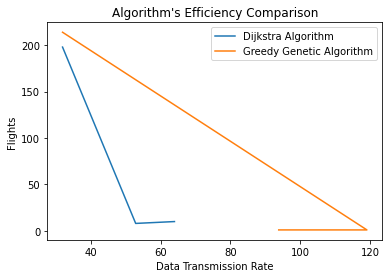

In [23]:
DAPlotting_x = []
DAPlotting_y = []

GGAPlot_x = []
GGAPlot_y = []

pointer=0
for route in traversedPaths:
    if(rateOfDataFlow[pointer] not in DAPlotting_x):
        DAPlotting_x.append(rateOfDataFlow[pointer])
        DAPlotting_y.append(len(route)-1)
    else : 
        index = DAPlotting_x.index(rateOfDataFlow[pointer])
        DAPlotting_y[index] += (len(route)-1)
    pointer+=1

for route in (HeathrowGS_TraversedPath[0]+NewarkGS_TraversedPath[0]):
    rate = bestPossibleTransmissionRateBetweenNodes(route, route[-1])
    if(rate not in GGAPlot_x):
        GGAPlot_x.append(rate)
        GGAPlot_y.append(len(route)-1)
    else:
        index = GGAPlot_x.index(rate)
        GGAPlot_y[index] += (len(route)-1)

plt.plot(DAPlotting_x, DAPlotting_y, label="Dijkstra Algorithm")
plt.plot(GGAPlot_x, GGAPlot_y, label="Greedy Genetic Algorithm")
plt.legend()
plt.xlabel('Data Transmission Rate')
plt.ylabel('Flights')
plt.title("Algorithm's Efficiency Comparison")
plt.show()

#### Result Evaluation & Validation - Multi-Objective Optimization

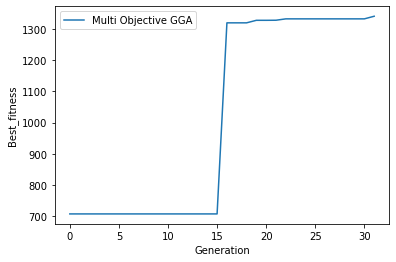

In [24]:
plt.plot(sorted(HeathrowGS_TraversedPath_Multi[1] + NewarkGS_TraversedPath_Multi[1]), label='Multi Objective GGA')
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Best_fitness')
plt.show()